In [1]:
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import numpy as np
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import keras.backend as K
from functools import partial
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

def weight_variable(shape):
    return K.truncated_normal(shape, stddev = 0.01)

In [3]:
#データの読み込み
use_data = pd.read_csv(filepath_or_buffer="multi_data.csv", encoding="utf_8", sep=",")
print(len(use_data))
use_data.info()

20000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
screen_name    20000 non-null object
user_id        20000 non-null float64
tweet_id       20000 non-null float64
tweet          20000 non-null object
tweet2         20000 non-null object
postdate       20000 non-null object
cos_day        20000 non-null float64
sin_day        20000 non-null float64
tag            20000 non-null object
image_url      20000 non-null object
image          20000 non-null int64
retweet        20000 non-null float64
tag2           6063 non-null object
user_id2       20000 non-null int64
dtypes: float64(5), int64(2), object(7)
memory usage: 2.1+ MB


In [4]:
maxlen = 50
train = 0.7
validation = 0.1
max_words = 20000

#データをランダムにシャッフル
use_data_s = use_data.sample(frac=1, random_state=150)

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(use_data_s['tweet2'])
sequences = tokenizer.texts_to_sequences(use_data_s['tweet2'])

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

#user_idをnp行列に変換
post_user = np.array(use_data['user_id2'])

#ラベルをバイナリの行列に変換
categorical_labels = to_categorical(use_data_s['retweet'])
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(post_user.shape))
print("Shape of label tensor:{}".format(labels.shape))


indices = [int(len(labels) * n) for n in [train, train + validation]]
x1_train, x1_val, x1_test = np.split(data, indices)
x2_train, x2_val, x2_test = np.split(post_user, indices)
y_train, y_val, y_test = np.split(labels, indices)

Found 20281 unique tokens.
Shape of data tensor:(20000, 50)
Shape of label tensor:(20000,)
Shape of label tensor:(20000, 2)


In [5]:
p_input = Input(shape=(50, ), dtype='int32', name='Input_postText')
i_input = Input(shape=(1, ), name='Input_ids')

#テキストの学習
em = Embedding(input_dim=20000, output_dim=50, input_length=50, name='Embedding')(p_input)
d_em = Dropout(0.5)(em)
lstm_out = LSTM(32, kernel_initializer=weight_variable , name='LSTM')(d_em)
d_lstm_out = Dropout(0.5)(lstm_out)
#2つ目のデータ学習
i2 = Dense(16, activation='relu', name = 'dence1')(i_input)
d_i2 = Dropout(0.5)(i2)
x = concatenate([d_lstm_out, d_i2], name='merge1')

m2 = Dense(16, activation='relu', name = 'dence')(x)
d_m2 = Dropout(0.5)(m2)
output = Dense(2, activation='softmax', name = 'output')(d_m2)

optimizer = Adam(lr=1e-4)
model = Model(inputs=[p_input, i_input], outputs = output)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_image/model2.png')


early_stopping = EarlyStopping(patience=2, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_postText (InputLayer)     (None, 50)           0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 50, 50)       1000000     Input_postText[0][0]             
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 50)       0           Embedding[0][0]                  
__________________________________________________________________________________________________
Input_ids (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
LSTM (LSTM

In [6]:
history = model.fit([x1_train, x2_train], y_train,
                    epochs=100, 
                    batch_size=256,
                    validation_data=([x1_val, x2_val], y_val),
                   callbacks=[early_stopping])

Train on 14000 samples, validate on 1999 samples
Epoch 1/100
14000/14000 [==============================] - 8s 575us/step - loss: 1.2780 - acc: 0.5027 - macro_precision: 0.5038 - macro_recall: 0.5033 - macro_f_measure: 0.5036 - val_loss: 0.7026 - val_acc: 0.4962 - val_macro_precision: 0.4988 - val_macro_recall: 0.4991 - val_macro_f_measure: 0.4989
Epoch 2/100
14000/14000 [==============================] - 8s 594us/step - loss: 0.7720 - acc: 0.5082 - macro_precision: 0.5084 - macro_recall: 0.5079 - macro_f_measure: 0.5081 - val_loss: 0.6928 - val_acc: 0.5063 - val_macro_precision: 0.2531 - val_macro_recall: 0.5000 - val_macro_f_measure: 0.3360
Epoch 3/100
14000/14000 [==============================] - 8s 556us/step - loss: 0.7083 - acc: 0.5079 - macro_precision: 0.5098 - macro_recall: 0.5081 - macro_f_measure: 0.5089 - val_loss: 0.6924 - val_acc: 0.5063 - val_macro_precision: 0.2531 - val_macro_recall: 0.5000 - val_macro_f_measure: 0.3360
Epoch 4/100
14000/14000 [=======================

In [11]:
loss_and_metrics = model.evaluate([x1_test, x2_test], y_test)
print(loss_and_metrics)

4001/4001 [==============================] - 1s 319us/step
[0.5383722172325891, 0.7505623594101475, 0.7552118389435454, 0.7513141527053149, 0.7531169994983993]


In [14]:
model.metrics_names

['loss', 'acc', 'macro_precision', 'macro_recall', 'macro_f_measure']

In [25]:
#予測
classes = model.predict([x1_test, x2_test])
#予測結果を保存して与えたデータと結合
columns = ['not publish', 'publish']
result = pd.DataFrame(classes, columns = columns)
test_data = use_data_s[15998:19999]
n_test_data = test_data.reset_index()
predict_result = n_test_data.join(result)
predict_result.drop(['user_id','tweet_id','tweet2', 'cos_day','sin_day', 'image_url', 'tag2', 'user_id2'], axis=1, inplace=True)

In [34]:
#予測結果の書き出し
predict_result.to_csv("result/A/result.csv",index=False, sep=",")

<Figure size 432x288 with 0 Axes>

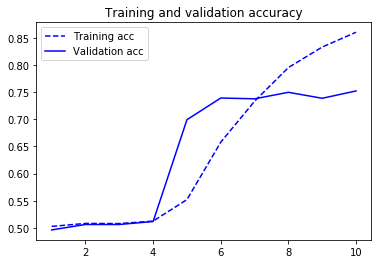

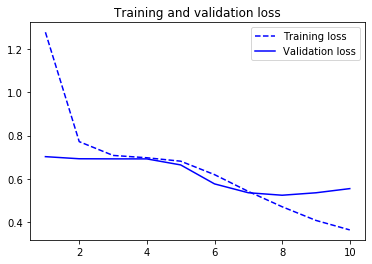

<Figure size 432x288 with 0 Axes>

In [9]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig("result/A/test_and_val_acc.png")

plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig("result/A/test_and_val_loss.png")

plt.figure()

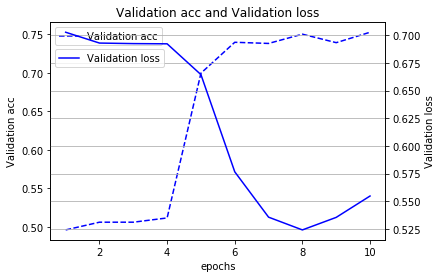

In [10]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Validation acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Validation acc and Validation loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Validation acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Validation loss')
#plt.savefig("result/A/val_acc_loss.png")
plt.show()

In [14]:
model.save('Datas/models/model1_dA.h5')

numpy.ndarray